# Comparison of model outputs

Aims: 

* Compare probability predictions between logistic regression, random forests, and neural networks

* Compare classifcations between logistic regression, random forests, and neural networks

* Compare classifcations between logistic regression, random forests neural networks, and actual classification (whether thrombolysis was given).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

## Load data

In [2]:
model_probs_test = pd.read_csv(
    './individual_model_output/probabilities_test.csv')

## Define the cutoff for classification

In [3]:
cut_off = 0.5

## Define function to set the colour for each point on the plot

In [4]:
def set_point_colour(s1, s2, cut_off):
    """
    s1 and s2 are series containing each model output for a number of instances
    cut_off is a float to classify each instance
    Returns series with a colour per instance to define whether there is a 
    match in the classification between the two models
    """
    # the classifications
    mask1 = s1 >= cut_off    
    mask2 = s2 >= cut_off
    mask3 = mask1 == mask2
    
    # initialise series with size the number of instances
    c = s1.copy(deep=True)
    # initialise with value 'r'
    c[:] = 'r'
    # value 'g' for those that match classification
    c[mask3] = 'g'
    
    return(c)

## Compare probababilties

Colour the points depending on whether the two models agree in their prediction.

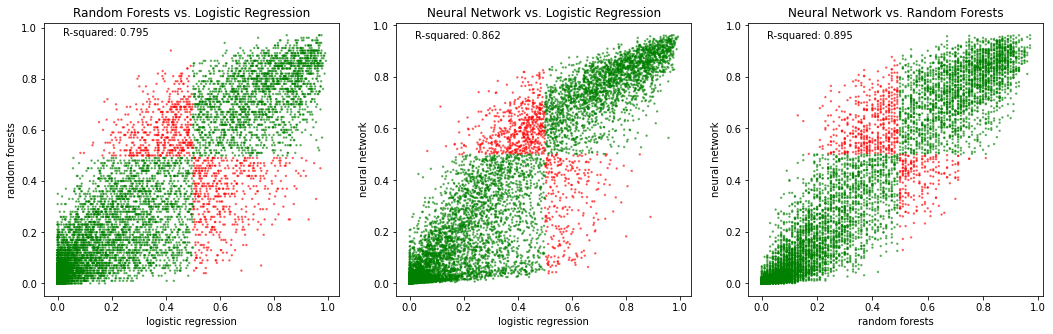

In [5]:
fig = plt.figure(figsize=(15,5))

# Random Forests vs. Logistic Regression
ax1 = fig.add_subplot(131)
r_square = np.corrcoef(model_probs_test['logistic_regression'],
           model_probs_test['random_forest'])[0][1] ** 2
c = set_point_colour(model_probs_test['logistic_regression'],
                     model_probs_test['random_forest'],
                     cut_off)
ax1.scatter(model_probs_test['logistic_regression'],
            model_probs_test['random_forest'],
            alpha=0.5, s=2, color = c)
ax1.set_xlabel('logistic regression')
ax1.set_ylabel('random forests')
ax1.set_title('Random Forests vs. Logistic Regression')
txt = f'R-squared: {r_square:0.3f}'
ax1.text(0.02, 0.97, txt)

# Neural network vs. Logistic Regression
ax2 = fig.add_subplot(132)
r_square = np.corrcoef(model_probs_test['logistic_regression'],
           model_probs_test['neural_net'])[0][1] ** 2
c = set_point_colour(model_probs_test['logistic_regression'],
                     model_probs_test['neural_net'],
                     cut_off)
ax2.scatter(model_probs_test['logistic_regression'],
            model_probs_test['neural_net'],
            alpha=0.5, s=2, color = c)
ax2.set_xlabel('logistic regression')
ax2.set_ylabel('neural network')
ax2.set_title('Neural Network vs. Logistic Regression')
txt = f'R-squared: {r_square:0.3f}'
ax2.text(0.02, 0.95, txt)

# Neural Network vs. Random Forests
ax3 = fig.add_subplot(133)
r_square = np.corrcoef(model_probs_test['random_forest'],
           model_probs_test['neural_net'])[0][1] ** 2
c = set_point_colour(model_probs_test['neural_net'],
                     model_probs_test['random_forest'],
                     cut_off)
ax3.scatter(model_probs_test['random_forest'],
           model_probs_test['neural_net'],
           alpha=0.5, s=2, color = c)
ax3.set_xlabel('random forests')
ax3.set_ylabel('neural network')
ax3.set_title('Neural Network vs. Random Forests')
txt = f'R-squared: {r_square:0.3f}'
ax3.text(0.02, 0.95, txt)


plt.tight_layout(pad=2)
plt.savefig('./ensemble_output/model_fits_scatter.png', dpi=300)
plt.show()

## Compare classification

In [6]:
classification = model_probs_test >= cut_off

Check agreement between logistic regression and random forests

In [7]:
agree = classification['logistic_regression'] == classification['random_forest']
np.mean(agree)

0.8925

Check agreement between logistic regression and neural network

In [8]:
agree = classification['logistic_regression'] == classification['neural_net']
np.mean(agree)

0.9136

Check agreement between random forests and neural network

In [9]:
agree = classification['random_forest'] == classification['neural_net']
np.mean(agree)

0.9269

Check agreement between all three model types

In [10]:
agree = (classification['logistic_regression'] == classification['random_forest']) & \
    (classification['logistic_regression'] == classification['neural_net'])
np.mean(agree)

0.8665

## Plot confusion matrix

Create function that returns the classification of each column based on the cutoff used for classification

In [11]:
def create_df_of_predictions(model_probs_test, cols, cut_off):
    """
    Given a dataframe with columns cols, return a dataframe that calssifies each 
    instance depending on whether the value exceeds the cutoff
    """
    df = pd.DataFrame()

    for c in cols:
        df[c] = model_probs_test[c] >= cut_off    

    return(df)

In [12]:
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    """
    Given a dataframe with at least
    two categorical columns, create a 
    confusion matrix of the count of the columns
    cross-counts
    
    use like:
    
    >>> confusion_matrix(test_df, 'actual_label', 'predicted_label')
    
    https://gist.github.com/Mlawrence95/f697aa939592fa3ef465c05821e1deed
    """
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )


In [13]:
def get_min_max_cm(df_prediction_all, model_pairings):
    """
    For each model pairings, create the confusion matrix and return the min and
    max value across all confusion matrices.
    """
    
    v_min = df_prediction_all.shape[0]
    v_max = 0

    for l in model_pairings:
        cm = confusion_matrix(df_prediction_all, l[0], l[1])
        v_min = min(v_min, cm.min().min())        
        v_max = max(v_max, cm.max().max())        
   
    return(v_min, v_max)

For each model, create the prediction based on the cut_off for classification

In [14]:
df_prediction = create_df_of_predictions(
                        model_probs_test,
                        ["random_forest","neural_net", "logistic_regression"],
                        cut_off)

For each model pairing, calculate the confusion matrix and store the min and max values across all. Need this to ensure all of the subplots use the same range.

In [15]:
model_pairings = [["logistic_regression","random_forest"],
                  ["logistic_regression","neural_net"],
                  ["random_forest","neural_net"]]

v_min, v_max = get_min_max_cm(df_prediction, model_pairings)

Create a figure with 3 heatmaps using subplots (a column for each subplot)
Ivert the y axis so that it has the same order as the scatter plots above (i.e. True on top)

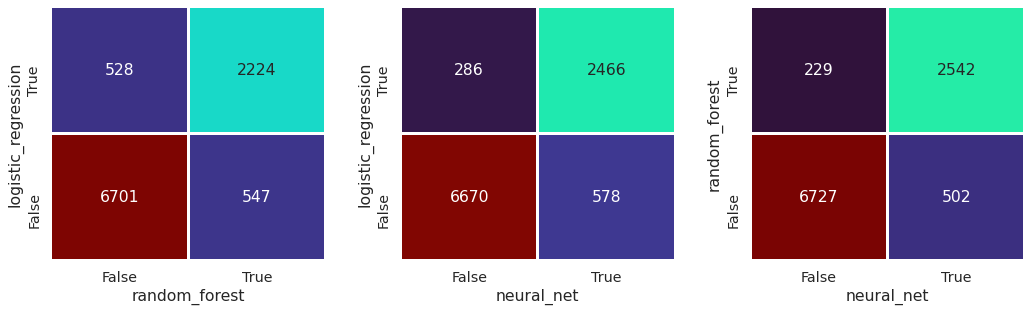

In [16]:
plt.figure(figsize=(15,5))

# set label size
sn.set(font_scale=1.3)

c_bar = False
for i in range(len(model_pairings)):
    plt.subplot(1,3,i+1)

    cm = confusion_matrix(df_prediction, 
                          model_pairings[i][0], 
                          model_pairings[i][1])

    # for the last plot, show the color bar
    #if i == (len(model_pairings)-1):
    #   c_bar = True
    
    # plot the heatmap
    sn.heatmap(cm, annot=True, cbar=c_bar, cmap = "turbo",
                    linecolor="w", linewidths=2, fmt='g',
                    vmin=v_min, vmax=v_max)
    
    # invert the y axis
    plt.gca().invert_yaxis()
    
plt.tight_layout(pad=2)
plt.savefig('./ensemble_output/confusion_matrix.png', dpi=300)
plt.show()

## Confusion matrix for models vs actual

Add the column of data "actual" to the df_prediction dataframe

In [17]:
df_prediction["actual"] = model_probs_test["actual"]
df_prediction["actual"].replace({1: True, 0: False}, inplace=True)
df_prediction.head()

,random_forest,neural_net,logistic_regression,actual
0,False,False,False,False
1,True,False,False,False
2,False,False,False,False
3,True,True,False,False
4,False,False,False,False


For each model pairing, calculate the confusion matrix and store the min and max values across all. Need this to ensure all of the subplots use the same range.

In [18]:
model_pairings = [["logistic_regression","actual"],
                  ["neural_net", "actual"],
                  ["random_forest","actual"]]

v_min, v_max = get_min_max_cm(df_prediction, model_pairings)

Create a figure with 3 heatmaps using subplots (a column for each subplot).
Invert the y axis so that it has the same order as the scatter plots above (i.e. True on top)

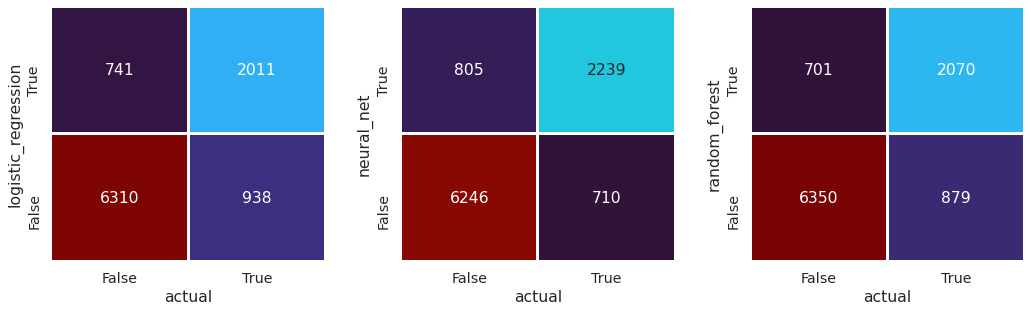

In [19]:
plt.figure(figsize=(15,5))

# set label size
sn.set(font_scale=1.3)

c_bar = False
for i in range(len(model_pairings)):
    plt.subplot(1,3,i+1)

    cm = confusion_matrix(df_prediction, 
                          model_pairings[i][0], 
                          model_pairings[i][1])

    # for the last plot, show the color bar
    #if i == (len(model_pairings)-1):
    #   c_bar = True
    
    # plot the heatmap
    sn.heatmap(cm, annot=True, cbar=c_bar, cmap = "turbo",
                    linecolor="w", linewidths=2, fmt='g',
                    vmin=v_min, vmax=v_max)
    
    # invert the y axis
    plt.gca().invert_yaxis()
    
plt.tight_layout(pad=2)
plt.savefig('./ensemble_output/confusion_matrix_actual.png', dpi=300)
plt.show()

## Observations

* There is high agreement in prediction between different model types, with random forests and neural networks having the highest agreement.

* There is greater agreement bewteen the different model types than between the models and reality.